<a href="https://colab.research.google.com/github/qcbegin/DSME6635-S24/blob/main/problem_sets/PS5_NLP_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 5 - Sentiment Analysis with Hugging Face

### Due at 12:30PM, Tuesday, March 26, 2024

Please first copy the CoLab file onto your own Google Drive. Finish the questions below and submit the **CoLab link** of your solutions in [this Google Sheet](https://docs.google.com/spreadsheets/d/1nOE-saTptG73WMCONDB1Z3pt-jHhmDA_1OHpQVHqQ1M/edit#gid=1954147409). The total achievable points are 8 for this problem set. Please name you solution as

- `Member1LastName_Member1FirstName-Member2LastName_Member2FirstName_PS5.ipynb` (e.g., `Cao_Leo-Zhang_Renyu_PS4.ipynb`)

In this problem set, your job is to directly use or finetune any transformer model at [**HuggingFace**](https://huggingface.co/) by calling its API.

Here's a [**Tutorial for Hugging Face Transformers**](https://colab.research.google.com/drive/13r94i6Fh4oYf-eJRSi7S_y_cen5NYkBm?usp=sharing).

As in problem set 4, you will work with the famous [IMDB review data from Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb). Your job is to classify the **first 1,000 sentences from the imdb database** and report the accuracy. You should try your best to achieve the highest sentiment classification accuracy as you can. You are encouraged to finetune some off-the-shelf models to strengthen the performance. You can also try some close-sourced large language models (e.g., GPT-4, Gemini-1.5, and Claude-3) by calling their APIs and leveraging VPNs.

In [1]:
from keras.datasets import imdb
import numpy as np
import transformers

### BEGIN YOUR SOLUTION

from datasets import load_dataset, DatasetDict
from torch.utils.data import Dataset, DataLoader
from keras.utils import pad_sequences
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(num_words=20000, maxlen=100):
    """
    This function load the imdb data.
    Input:
        num_words: the number of unique words we will consider with highest frequency.
        maxlen: the maximum length of each sentence.
    Output:
        X_train, X_test: a list of items, each item has a list of numbers where each
        number represents a word.
        y_train, y_test: a list of one or zeros where one represents positive review
        and zero represents negative review.
    """
    X_train = y_train = X_test = y_test = None
    ### BEGIN SOLUTION
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
    X_train = pad_sequences(X_train, maxlen=maxlen)
    X_test = pad_sequences(X_test, maxlen=maxlen)
    ### END SOLUTION
    return X_train, y_train, X_test, y_test

def find_sentence(train_sentence):
    """
    This function takes a list of numbers in IMDB data and translates it into words.
    Input:
        train_sentence: a list of numbers where numbers represent words
    Output:
        final_sentence: a string consists of words in the list in sequential
        order and separated by space.
    """
    final_sentence = ""

    word_index = imdb.get_word_index()
    index_word = {v: k for k, v in word_index.items()}
    index_word[0] = '[PAD]'
    final_sentence = ' '.join(index_word[i] for i in train_sentence if i != 0)

    return final_sentence


class IMDBDataset(Dataset):
    def __init__(self, encodings=None, labels=None, texts=None, tokenizer=None):
        if encodings is not None:
            self.encodings = encodings
        else:
            self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.encodings.input_ids)

In [2]:
X_train, y_train, X_test, y_test = load_data()

## Fine-tuning pre-trained models: Training Code

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)

# Specify the number or ratio of the original dataset assigned to the validation subset
val_size = 0.2  # 20% of the original dataset will be assigned to the validation subset

# Split the training data into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train[:25000], y_train[:25000], test_size=val_size, random_state=0)
X_train = [find_sentence(x) for x in X_train]
X_val = [find_sentence(x) for x in X_val]

# Print the sizes of the train and validation subsets
print("Train subset size:", len(X_train))
print("Validation subset size:", len(X_val))

train_dataset = IMDBDataset(texts=X_train, labels=y_train, tokenizer=tokenizer)
val_dataset = IMDBDataset(texts=X_val, labels=y_val, tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Train subset size: 20000
Validation subset size: 5000


In [5]:
def compute_metrics(p):    
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

args = TrainingArguments(
    output_dir="output",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    save_strategy="epoch",                  # Save the model at the end of every epoch
    evaluation_strategy="epoch",            # Evaluate the model at the end of every epoch
    save_total_limit=5,                   
    seed=0,
    load_best_model_at_end=True)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

# train the model
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/6250 [00:00<?, ?it/s]

/var/folders/wc/3xbh93cd4jsc0jwxp4j7hdp40000gn/T/ipykernel_16172/2664452301.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6304, 'grad_norm': 5.774693965911865, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.4}
{'loss': 0.4624, 'grad_norm': 2.9471142292022705, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.8}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.4271415174007416, 'eval_accuracy': 0.8008, 'eval_precision': 0.8762937407589946, 'eval_recall': 0.7047166072136346, 'eval_f1': 0.781195079086116, 'eval_runtime': 73.9394, 'eval_samples_per_second': 67.623, 'eval_steps_per_second': 4.233, 'epoch': 1.0}


/var/folders/wc/3xbh93cd4jsc0jwxp4j7hdp40000gn/T/ipykernel_16172/2664452301.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3755, 'grad_norm': 24.208892822265625, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}
{'loss': 0.3207, 'grad_norm': 11.240602493286133, 'learning_rate': 1.3600000000000002e-05, 'epoch': 1.6}
{'loss': 0.2989, 'grad_norm': 5.148575782775879, 'learning_rate': 1.2e-05, 'epoch': 2.0}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.4007644057273865, 'eval_accuracy': 0.8294, 'eval_precision': 0.8795454545454545, 'eval_recall': 0.7669441141498217, 'eval_f1': 0.8193944526783825, 'eval_runtime': 71.8276, 'eval_samples_per_second': 69.611, 'eval_steps_per_second': 4.358, 'epoch': 2.0}


/var/folders/wc/3xbh93cd4jsc0jwxp4j7hdp40000gn/T/ipykernel_16172/2664452301.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2182, 'grad_norm': 2.1553761959075928, 'learning_rate': 1.04e-05, 'epoch': 2.4}
{'loss': 0.2197, 'grad_norm': 2.636873722076416, 'learning_rate': 8.8e-06, 'epoch': 2.8}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.457369863986969, 'eval_accuracy': 0.8434, 'eval_precision': 0.8302961275626424, 'eval_recall': 0.8668252080856124, 'eval_f1': 0.8481675392670157, 'eval_runtime': 61.5497, 'eval_samples_per_second': 81.235, 'eval_steps_per_second': 5.085, 'epoch': 3.0}


/var/folders/wc/3xbh93cd4jsc0jwxp4j7hdp40000gn/T/ipykernel_16172/2664452301.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1741, 'grad_norm': 21.866836547851562, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.2}
{'loss': 0.1473, 'grad_norm': 39.29494094848633, 'learning_rate': 5.600000000000001e-06, 'epoch': 3.6}
{'loss': 0.161, 'grad_norm': 23.906898498535156, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.6558096408843994, 'eval_accuracy': 0.839, 'eval_precision': 0.8018271257905832, 'eval_recall': 0.904478795085216, 'eval_f1': 0.8500651890482399, 'eval_runtime': 37.4942, 'eval_samples_per_second': 133.354, 'eval_steps_per_second': 8.348, 'epoch': 4.0}


/var/folders/wc/3xbh93cd4jsc0jwxp4j7hdp40000gn/T/ipykernel_16172/2664452301.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0982, 'grad_norm': 0.8527888059616089, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.4}
{'loss': 0.1045, 'grad_norm': 0.06326840072870255, 'learning_rate': 8.000000000000001e-07, 'epoch': 4.8}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.7071170210838318, 'eval_accuracy': 0.8478, 'eval_precision': 0.8342185128983308, 'eval_recall': 0.8715814506539834, 'eval_f1': 0.8524907927893002, 'eval_runtime': 62.7147, 'eval_samples_per_second': 79.726, 'eval_steps_per_second': 4.991, 'epoch': 5.0}
{'train_runtime': 5438.8952, 'train_samples_per_second': 18.386, 'train_steps_per_second': 1.149, 'train_loss': 0.26120069946289065, 'epoch': 5.0}


TrainOutput(global_step=6250, training_loss=0.26120069946289065, metrics={'train_runtime': 5438.8952, 'train_samples_per_second': 18.386, 'train_steps_per_second': 1.149, 'train_loss': 0.26120069946289065, 'epoch': 5.0})

In [8]:
# predict on the test data
raw_pred, _, _ = trainer.predict(test_dataset) 

# export the predictions
y_pred = np.argmax(raw_pred, axis=1)

# calculate the accuracy
print("Accuracy:", accuracy_score(y_test[:1000], y_pred))

/var/folders/wc/3xbh93cd4jsc0jwxp4j7hdp40000gn/T/ipykernel_98514/2608633430.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/63 [00:00<?, ?it/s]

Accuracy: 0.593


## Fine-tuning pre-trained models: Results

For training our model, we utilize all the trainning data and employ the `distilbert-base-uncased` model as our baseline pre-trained model.

Here’s a concise overview of the training settings:

- Learning Rate: 2e-5
- Batch Size: 16 (for both training and evaluation)
- Epochs: 5
- Evaluation Strategy: epoch
- Early Stopping: Patience of 3, to prevent overfitting by halting training if the validation performance does not improve.

These values are chosen to efficiently fine-tune the model on our specific task, balancing between performance and computational resources.

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# load the test data
X_test = [find_sentence(x) for x in X_test[:1000]]
y_test = y_test[:1000]
X_train, X_val, y_train, y_val = train_test_split(X_train[:25000], y_train[:25000], test_size=0.2, random_state=0)
X_val = [find_sentence(x) for x in X_val]
y_val = y_val

# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
test_dataset = IMDBDataset(texts = X_test, labels = y_test, tokenizer=tokenizer)
val_dataset = IMDBDataset(texts = X_val, labels = y_val, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

c:\Users\LiXinyu\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LiXinyu\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [4]:
from transformers import Trainer
import pandas as pd

# load the checkpoints and draw the trend of the loss
models = [AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)]
checkpoints = [AutoModelForSequenceClassification.from_pretrained(f"output/checkpoint-{i}") for i in [1250,2500,3750,5000,6250]]
models = models + checkpoints

def model_pred(model, ref_data):
    model.eval()
    predictions = []
    with torch.no_grad():
        # use Trainer.predict to predict the test set
        trainer = Trainer(model=model)
        preds = trainer.predict(ref_data)
        predictions = np.argmax(preds.predictions, axis=1)
    return predictions

# Create a DataFrame to store the accuracy of each model
accs_test = []
accs_val = []

for model in models:
    preds_test = model_pred(model, test_dataset)
    preds_val = model_pred(model, val_dataset)
    accs_test.append(accuracy_score(y_test, preds_test))
    accs_val.append(accuracy_score(y_val, preds_val))

accs = pd.DataFrame({"test": accs_test, "val": accs_val, "steps": [0, 1250, 2500, 3750, 5000, 6250], "model":"DistilBERT"})

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert/distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

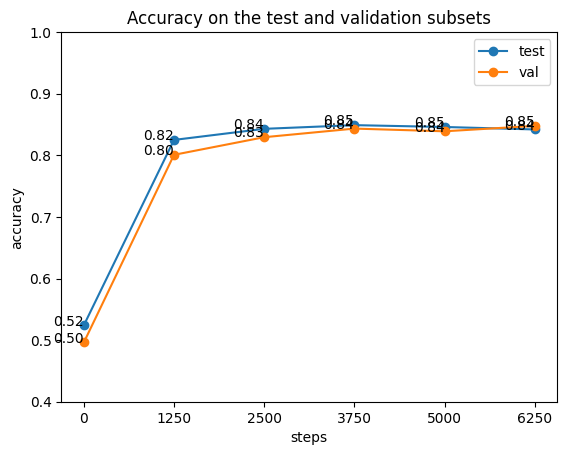

In [5]:
# visualize the accuracy of each model
accs.plot(x="steps", y=["test", "val"], kind="line", marker="o")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.title("Accuracy on the test and validation subsets")
plt.xticks([0, 1250, 2500, 3750, 5000, 6250])
plt.ylim(0.4, 1)

for i in range(len(accs)):
    plt.text(accs["steps"][i], accs["test"][i], f"{accs['test'][i]:.2f}", ha="right")
    plt.text(accs["steps"][i], accs["val"][i], f"{accs['val'][i]:.2f}", ha="right")

plt.show()

In [11]:
## This code block shows the results of DistilRoBERTa model training and evaluation
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")
test_dataset = IMDBDataset(texts = X_test, labels = y_test, tokenizer=tokenizer)
val_dataset = IMDBDataset(texts = X_val, labels = y_val, tokenizer=tokenizer)

# load the checkpoints and draw the trend of the loss
models = [AutoModelForSequenceClassification.from_pretrained("distilbert/distilroberta-base", num_labels=2)]
checkpoints = [AutoModelForSequenceClassification.from_pretrained(f"output_roberta_imdb/checkpoint-{i}") for i in [1250,2500,3750,5000,6250]]
models = models + checkpoints

# Create a DataFrame to store the accuracy of each model
accs_test = []
accs_val = []

for model in models:
    preds_test = model_pred(model, test_dataset)
    preds_val = model_pred(model, val_dataset)
    accs_test.append(accuracy_score(y_test, preds_test))
    accs_val.append(accuracy_score(y_val, preds_val))


Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'cla

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\3484952106.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\LiXinyu\AppData\Local\Temp\ipykernel_20020\1265267194.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accs = accs.append(pd.DataFrame({"test": accs_test, "val": accs_val, "steps": [0, 1250, 2500, 3750, 5000, 6250], "model": "DistilRoBERTa"})).reset_index(drop=True)


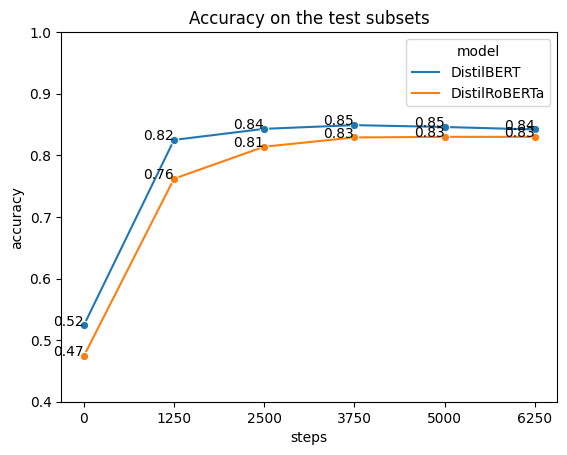

In [22]:
# append results to previous DataFrame and add a column for model names
accs = accs.append(pd.DataFrame({"test": accs_test, "val": accs_val, "steps": [0, 1250, 2500, 3750, 5000, 6250], "model": "DistilRoBERTa"})).reset_index(drop=True)

sns.lineplot(data = accs, x="steps", y="test", hue="model", marker="o")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.title("Accuracy on the test subsets")
plt.xticks([0, 1250, 2500, 3750, 5000, 6250])
plt.ylim(0.4, 1)

for i in range(len(accs)):
    plt.text(accs["steps"][i], accs["test"][i], f"{accs['test'][i]:.2f}", ha="right")

plt.show()

## LLM Application

The following code shows an simple example on using LLM (llama-2) to tell the sentiment of a movie review:

In [ ]:
from transformers import AutoTokenizer
import transformers
import torch

model = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto"
)

def prompt_completion(rtext):
    rtext = rtext[:200]
    prompt = f'''
    What is the sentiment of this segmented movie review? Return your selection as "[NEGATIVE]" or "[POSITIVE]".
    Review: {rtext}
    '''
    return prompt

def ans_extract(seq):
    gtext = seq
    ans = re.findall(r'\[[A-Za-z]*\]', gtext)[-1]
    return ans

preds = []
prompts = [prompt_completion(t) for t in X_test]

for out in pipeline(prompts, do_sample=True, top_k=10, num_return_sequences=1, eos_token_id=tokenizer.eos_token_id, max_length=350):
    preds.append(ans_extract(out[0]['generated_text']))

In [10]:
import re

# Load the results from the llama_results_temp.txt file
with open("llama_results_temp.txt", "r+") as f:
    results = f.readlines()

# Extract the labels from the results
results = [ re.findall(r'\[[A-Za-z]*\]', x)[0]  for x in results]
mat = {'[POSITIVE]':1, '[NEGATIVE]':0}

# Convert the labels to integers
results = [mat.get(x, 2) for x in results]

# Calculate the accuracy
print("Accuracy:", accuracy_score(y_test[:1000], results))

Accuracy: 0.511


## Use Pre-trained Models Directly

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader

In [10]:
X_test = [find_sentence(x) for x in X_test[:1000]]
y_test = y_test[:1000]

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
test_dataset = IMDBDataset(texts = X_test, labels = y_test, tokenizer=tokenizer)

In [68]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

def predict_accuracy(model, tokenizer, test_data, batch_size=32):

    # Tokenize the input data
    test_dataset = IMDBDataset(tokenizer=tokenizer, texts=test_data[0], labels=test_data[1])

    # Create a dataset from the tokenized input data
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # Predict and calculate accuracy in batches
    y_pred = []
    for batch in test_dataloader:
        # Predict using the model
        with torch.no_grad():
            preds = model(**batch)

        batch_y_pred = preds.logits.argmax(dim=-1)
        y_pred.extend(batch_y_pred.numpy())

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset.labels, y_pred)
    # print(model.config.id2label)
    print(y_pred)
    print("Accuracy:", accuracy)
    return accuracy

# Define the mapping between class labels and class indices
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# Load the model and tokenizer
model_names = ["distilbert/distilbert-base-uncased", "distilbert/distilroberta-base", "distilbert/distilgpt2", "distilbert/distilbert-base-uncased-finetuned-sst-2-english"]
accuracies = []

for model_name in model_names[3:]:
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.eos_token_id
    # Call the function to predict and export accuracy
    accuracy = predict_accuracy(model, tokenizer, (X_test, y_test), batch_size=100)
    accuracies.append(accuracy)

/var/folders/wc/3xbh93cd4jsc0jwxp4j7hdp40000gn/T/ipykernel_89820/2608633430.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [67]:
dict(zip(model_names, accuracies))

{'distilbert/distilbert-base-uncased': 0.475,
 'distilbert/distilroberta-base': 0.474,
 'distilbert/distilgpt2': 0.474,
 'distilbert/distilbert-base-uncased-finetuned-sst-2-english': 0.499}

In [24]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
results = []
batch_size = 100

for i in range(0, len(test_dataset), batch_size):
    batch = test_dataset[i:i+batch_size]
    batch = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
    output = model(**batch)
    label = np.argmax(output[0].detach().numpy()[:,[0,2]], axis=1)
    results.extend(label)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [25]:
np.mean(results == y_test[:1000])

0.495

In [6]:
from collections import Counter

Counter(y_test[:1000])

Counter({0: 526, 1: 474})

## End of Problem Set 5.